In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

df = pd.read_csv('datasets/train_v2_cleaned_damage_inc.csv')

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = df.drop(['outcome_damage_inc'],1)
y = df['outcome_damage_inc']

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X_trainval,y_trainval, test_size=0.2, random_state=1234)

In [5]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=10000, max_iter=200) 
logreg.fit(X_train, y_train)

LogisticRegression(C=10000, max_iter=200)

In [6]:
print(logreg.score(X_train, y_train))
print(logreg.score(X_val, y_val))

0.751875
0.7725


In [7]:
y_val_pred = logreg.predict(X_val)
y_val_pred_prob = logreg.predict_proba(X_val)

In [8]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_val, y_val_pred)
print(confusion_matrix)

[[588  22]
 [160  30]]


In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.96      0.87       610
         1.0       0.58      0.16      0.25       190

    accuracy                           0.77       800
   macro avg       0.68      0.56      0.56       800
weighted avg       0.74      0.77      0.72       800



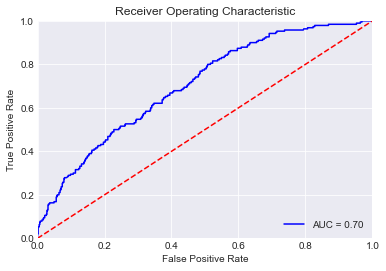

In [10]:
import sklearn.metrics as metrics
preds = y_val_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## calibratie

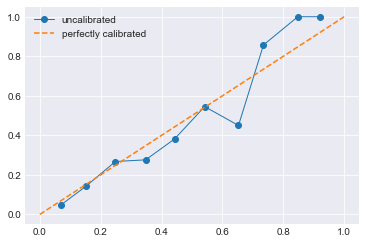

In [11]:
from sklearn.calibration import calibration_curve
y_pred_val_prob = logreg.predict_proba(X_val)

fop, mpv = calibration_curve(y_val,y_pred_val_prob[:,1],n_bins=10)

plt.plot(mpv,fop, marker='o', linewidth=1, label='uncalibrated')
plt.plot([0,1],[0,1],linestyle='--', label='perfectly calibrated')
plt.legend()

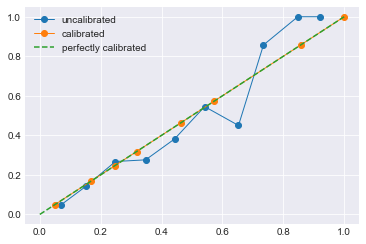

In [12]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
isotonic = CalibratedClassifierCV(logreg, cv='prefit', method='isotonic')
isotonic.fit(X_val, y_val)

y_val_pred_prob_c = isotonic.predict_proba(X_val)
fop, mpv = calibration_curve(y_val,y_pred_val_prob[:,1],n_bins=10)
fop_c, mpv_c = calibration_curve(y_val,y_val_pred_prob_c[:,1],n_bins=10)
plt.plot(mpv,fop, marker='o', linewidth=1, label='uncalibrated')
plt.plot(mpv_c,fop_c, marker='o', linewidth=1, label='calibrated')
plt.plot([0,1],[0,1],linestyle='--', label='perfectly calibrated')
plt.legend()
plt.show()

In [13]:
y_val_pred = logreg.predict(X_val)
y_val_pred_c = isotonic.predict(X_val)

print(classification_report(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred_c))

              precision    recall  f1-score   support

         0.0       0.79      0.96      0.87       610
         1.0       0.58      0.16      0.25       190

    accuracy                           0.77       800
   macro avg       0.68      0.56      0.56       800
weighted avg       0.74      0.77      0.72       800

              precision    recall  f1-score   support

         0.0       0.77      0.99      0.87       610
         1.0       0.78      0.07      0.13       190

    accuracy                           0.78       800
   macro avg       0.78      0.53      0.50       800
weighted avg       0.78      0.78      0.70       800



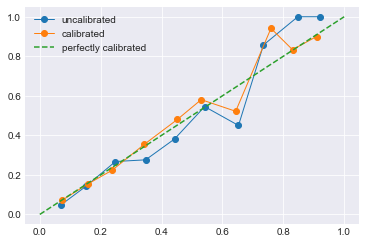

              precision    recall  f1-score   support

         0.0       0.77      0.99      0.87       610
         1.0       0.78      0.07      0.13       190

    accuracy                           0.78       800
   macro avg       0.78      0.53      0.50       800
weighted avg       0.78      0.78      0.70       800

              precision    recall  f1-score   support

         0.0       0.78      0.97      0.87       610
         1.0       0.60      0.13      0.21       190

    accuracy                           0.77       800
   macro avg       0.69      0.55      0.54       800
weighted avg       0.74      0.77      0.71       800



In [14]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
logreg2 = LogisticRegression(C=10000, max_iter=1000) 
isotonic2 = CalibratedClassifierCV(logreg2, cv=5, method='isotonic')
isotonic2.fit(X_trainval, y_trainval)


# The calibration plot
y_val_pred_prob_c2 = isotonic2.predict_proba(X_trainval)

fop, mpv = calibration_curve(y_val,y_pred_val_prob[:,1],n_bins=10)
fop_c, mpv_c = calibration_curve(y_trainval,y_val_pred_prob_c2[:,1],n_bins=10)

plt.plot(mpv,fop, marker='o', linewidth=1, label='uncalibrated')
plt.plot(mpv_c,fop_c, marker='o', linewidth=1, label='calibrated')
plt.plot([0,1],[0,1],linestyle='--', label='perfectly calibrated')
plt.legend()
plt.show()

y_val_pred_c2 = isotonic2.predict(X_val)
print(classification_report(y_val, y_val_pred_c))
print(classification_report(y_val, y_val_pred_c2))

## Polynomials + penalisatie

In [15]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train)
X_trainval_poly = poly.transform(X_trainval)
X_val_poly = poly.transform(X_val)

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

C = [round(x,5) for x in np.linspace(start = 0.0001, stop = 10, num = 1000)]
random_grid = {'C': C}
# The object to fit the model
logreg = LogisticRegression( max_iter=1000) 

# object for the randomised search
log_random = RandomizedSearchCV(estimator = logreg, param_distributions = random_grid, n_iter = 100,
                               cv = 3, verbose=2,  n_jobs=-1, random_state=1234)

#Fitting model (model+ calibration)
log_random.fit(X_trainval_poly, y_trainval)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.01011, 0.02012, 0.03013,
                                              0.04014, 0.05015, 0.06016,
                                              0.07017, 0.08018, 0.09019, 0.1002,
                                              0.11021, 0.12022, 0.13023,
                                              0.14024, 0.15025, 0.16026,
                                              0.17027, 0.18028, 0.19029, 0.2003,
                                              0.21031, 0.22032, 0.23033,
                                              0.24034, 0.25035, 0.26036,
                                              0.27037, 0.28038, 0.29039, ...]},
                   random_state=1234, verbose=2)

In [17]:
log_random.best_params_

{'C': 0.78087}

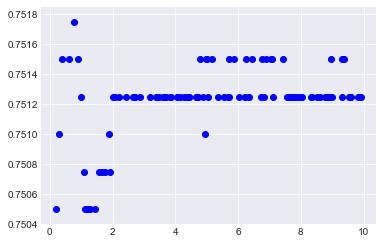

In [18]:
out2 = pd.DataFrame(log_random.cv_results_)
plt.ylim(out2['mean_test_score'].min()-0.0001, out2['mean_test_score'].max()+0.0001)
plt.scatter(out2['param_C'], out2['mean_test_score'], c='blue');


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer

prec_scorer = make_scorer(metrics.accuracy_score)
# other possibilities are metrics.recall_score, metrics.average_precision, ...

C = [x for x in np.linspace(start = 0.0001, stop = 2, num = 100)]

random_grid = {'C': C}

# The object to fit the model
logreg_balanced = LogisticRegression( max_iter=1000) 

# object for the randomised search
log_grid = GridSearchCV(estimator = logreg_balanced, param_grid = random_grid,
                                scoring=prec_scorer  , cv = 3, verbose=2,  n_jobs=-1)
isotonic_log = CalibratedClassifierCV(log_grid, cv=3, method='isotonic')

#Fitting model (model+ calibration)
isotonic_log.fit(X_trainval_poly, y_trainval)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


CalibratedClassifierCV(base_estimator=GridSearchCV(cv=3,
                                                   estimator=LogisticRegression(max_iter=1000),
                                                   n_jobs=-1,
                                                   param_grid={'C': [0.0001,
                                                                     0.0203010101010101,
                                                                     0.040502020202020206,
                                                                     0.06070303030303031,
                                                                     0.08090404040404041,
                                                                     0.10110505050505052,
                                                                     0.12130606060606061,
                                                                     0.1415070707070707,
                                                                     0.16170808

In [20]:
isotonic_log.score(X_val_poly, y_val)

0.77375

In [22]:
y_pred_poly = isotonic_log.predict(X_val_poly)
print(classification_report(y_val, y_pred_poly))
print(classification_report(y_val, y_val_pred_c2))

              precision    recall  f1-score   support

         0.0       0.78      0.97      0.87       610
         1.0       0.60      0.14      0.22       190

    accuracy                           0.77       800
   macro avg       0.69      0.55      0.55       800
weighted avg       0.74      0.77      0.71       800

              precision    recall  f1-score   support

         0.0       0.78      0.97      0.87       610
         1.0       0.60      0.13      0.21       190

    accuracy                           0.77       800
   macro avg       0.69      0.55      0.54       800
weighted avg       0.74      0.77      0.71       800



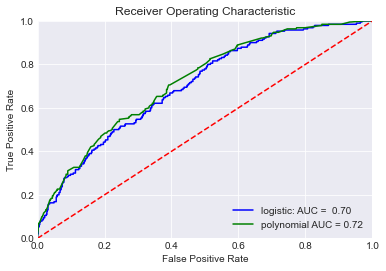

In [23]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
preds = y_val_pred_prob[:,1]
preds_poly = isotonic_log.predict_proba(X_val_poly)[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
fpr_p, tpr_p, threshold = metrics.roc_curve(y_val, preds_poly)

roc_auc = metrics.auc(fpr, tpr)
roc_auc_p = metrics.auc(fpr_p, tpr_p)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'logistic: AUC =  %0.2f' % roc_auc)
plt.plot(fpr_p, tpr_p, 'g', label = 'polynomial AUC = %0.2f' % roc_auc_p)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## knn

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
n_neighbors = np.arange(1,30)
param_grid = {'n_neighbors': n_neighbors}
knn = KNeighborsClassifier( )
grid_search = GridSearchCV(estimator = knn, param_grid = param_grid, scoring=prec_scorer ,cv = 3,  verbose=2, n_jobs = -1)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 29 candidates, totalling 87 fits


{'n_neighbors': 28}

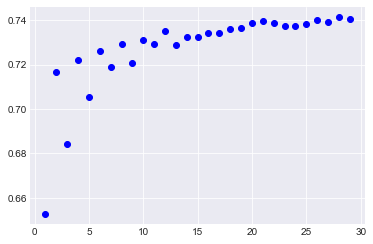

In [25]:
out2 = pd.DataFrame(grid_search.cv_results_)
xlabel_names = ['n_neighbors']
plt.scatter(out2['param_n_neighbors'], out2['mean_test_score'], c='blue');


In [26]:
y_pred_knn = grid_search.predict(X_val)
print(classification_report(y_val, y_pred_knn))

              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87       610
         1.0       0.83      0.03      0.05       190

    accuracy                           0.77       800
   macro avg       0.80      0.51      0.46       800
weighted avg       0.78      0.77      0.67       800



In [29]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.8, random_state=1703)
under = RandomUnderSampler(sampling_strategy=1)
pipeline = Pipeline([('o', over), ('u', under)])

X_train_smote, y_train_smote = pipeline.fit_resample(X_train.copy(), y_train.copy())
X_trainval_smote, y_trainval_smote = pipeline.fit_resample(X_trainval.copy(), y_trainval.copy())
np.bincount(y_trainval_smote)

array([2376, 2376], dtype=int64)

In [30]:
n_neighbors = np.arange(1,30)
param_grid = {'n_neighbors': n_neighbors}

knn_b = KNeighborsClassifier( )
grid_search_knn = GridSearchCV(estimator = knn, param_grid = param_grid, scoring=prec_scorer ,cv = 3,  verbose=2, n_jobs = -1)
isotonic_knn = CalibratedClassifierCV(grid_search_knn, cv=3, method='isotonic')


isotonic_knn.fit(X_trainval_smote, y_trainval_smote)


Fitting 3 folds for each of 29 candidates, totalling 87 fits
Fitting 3 folds for each of 29 candidates, totalling 87 fits
Fitting 3 folds for each of 29 candidates, totalling 87 fits


CalibratedClassifierCV(base_estimator=GridSearchCV(cv=3,
                                                   estimator=KNeighborsClassifier(),
                                                   n_jobs=-1,
                                                   param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
                                                   scoring=make_scorer(accuracy_score),
                                                   verbose=2),
                       cv=3, method='isotonic')

In [32]:
y_pred_knn_b = isotonic_knn.predict(X_val)
print(classification_report(y_val, y_pred_knn_b))
print(classification_report(y_val, y_val_pred_c2))

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97       610
         1.0       0.83      0.99      0.90       190

    accuracy                           0.95       800
   macro avg       0.91      0.96      0.94       800
weighted avg       0.96      0.95      0.95       800

              precision    recall  f1-score   support

         0.0       0.78      0.97      0.87       610
         1.0       0.60      0.13      0.21       190

    accuracy                           0.77       800
   macro avg       0.69      0.55      0.54       800
weighted avg       0.74      0.77      0.71       800



## gbm

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV


n_estimators = [int(x) for x in np.linspace(start = 100, stop = 250, num = 50)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 20, num = 20)]
min_samples_split = [int(x) for x in np.linspace(2, 10, num = 9)]
min_samples_leaf = [int(x) for x in np.linspace(1, 10, num = 10)]
learning_rate = [round(x,5) for x in np.linspace(start = 0.001, stop = 1.5, num = 50)]

random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
gbm = GradientBoostingClassifier()
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=4872, n_jobs = -1)
gbm_random.fit(X_train_smote, y_train_smote)
gbm_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'n_estimators': 136,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 15,
 'learning_rate': 0.45988}

In [34]:
y_pred_gbm = gbm_random.predict(X_test)
print(classification_report(y_test, y_pred_gbm))
print(classification_report(y_val, y_pred_knn_b))

              precision    recall  f1-score   support

         0.0       0.78      0.85      0.82       752
         1.0       0.38      0.27      0.32       248

    accuracy                           0.71      1000
   macro avg       0.58      0.56      0.57      1000
weighted avg       0.68      0.71      0.69      1000

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97       610
         1.0       0.83      0.99      0.90       190

    accuracy                           0.95       800
   macro avg       0.91      0.96      0.94       800
weighted avg       0.96      0.95      0.95       800



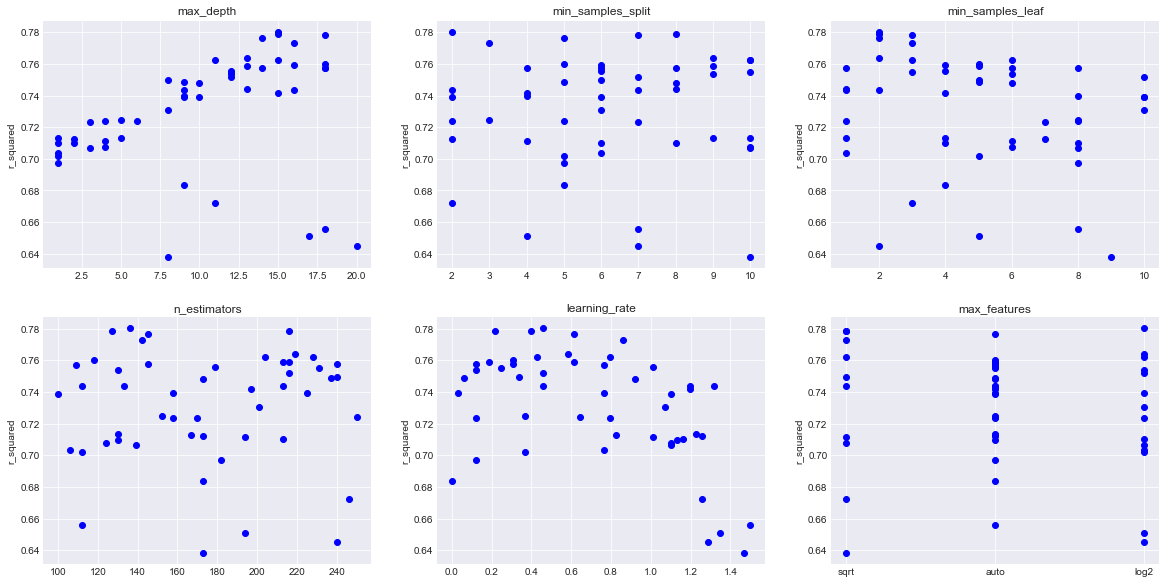

In [35]:
out2 = pd.DataFrame(gbm_random.cv_results_)

xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_learning_rate','param_max_features']

fig, axs = plt.subplots(2,3, figsize=(20,10))

axs[0,0].scatter(out2['param_max_depth'], out2['mean_test_score'], c='blue');
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out2['param_min_samples_split'], out2['mean_test_score'], c='blue');
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out2['param_min_samples_leaf'], out2['mean_test_score'], c='blue');
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out2['param_n_estimators'], out2['mean_test_score'], c='blue');
axs[1,0].set_title('n_estimators')

axs[1,1].scatter(out2['param_learning_rate'], out2['mean_test_score'], c='blue');
axs[1,1].set_title('learning_rate')

axs[1,2].scatter(out2['param_max_features'], out2['mean_test_score'], c='blue');
axs[1,2].set_title('max_features')

for ax in axs.flat: ax.set(ylabel='r_squared')

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

n_estimators = [int(x) for x in np.linspace(120, 140, num = 20)]
learning_rate = [x for x in np.linspace(0.3, 0.5, num = 20)]
max_features = ['log2']
max_depth = [15]
min_samples_split = [2,3,8]
min_samples_leaf = [2,3]
                                            
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
gbm = GradientBoostingClassifier()
gbm_grid = GridSearchCV(estimator = gbm, param_grid = random_grid,  cv = 3, verbose=2,  n_jobs = -1)

isotonic_gbm = CalibratedClassifierCV(gbm_grid, cv=3, method='isotonic')
isotonic_gbm.fit(X_trainval_smote, y_trainval_smote)

Fitting 3 folds for each of 2400 candidates, totalling 7200 fits
Fitting 3 folds for each of 2400 candidates, totalling 7200 fits
Fitting 3 folds for each of 2400 candidates, totalling 7200 fits


CalibratedClassifierCV(base_estimator=GridSearchCV(cv=3,
                                                   estimator=GradientBoostingClassifier(),
                                                   n_jobs=-1,
                                                   param_grid={'learning_rate': [0.3,
                                                                                 0.31052631578947365,
                                                                                 0.32105263157894737,
                                                                                 0.33157894736842103,
                                                                                 0.34210526315789475,
                                                                                 0.3526315789473684,
                                                                                 0.3631578947368421,
                                                                                 0.37368421052

In [37]:
y_pred_gbm = isotonic_gbm.predict(X_val)
print(classification_report(y_val, y_pred_gbm))
print(classification_report(y_val, y_pred_knn_b))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       610
         1.0       0.94      0.99      0.97       190

    accuracy                           0.98       800
   macro avg       0.97      0.99      0.98       800
weighted avg       0.98      0.98      0.98       800

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97       610
         1.0       0.83      0.99      0.90       190

    accuracy                           0.95       800
   macro avg       0.91      0.96      0.94       800
weighted avg       0.96      0.95      0.95       800



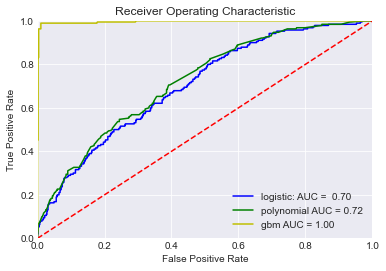

In [38]:
preds_gbm = isotonic_gbm.predict_proba(X_val)[:,1]


fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
fpr_p, tpr_p, threshold = metrics.roc_curve(y_val, preds_poly)
fpr_g, tpr_g, threshold = metrics.roc_curve(y_val, preds_gbm)

roc_auc = metrics.auc(fpr, tpr)
roc_auc_p = metrics.auc(fpr_p, tpr_p)
roc_auc_g = metrics.auc(fpr_g, tpr_g)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'logistic: AUC =  %0.2f' % roc_auc)
plt.plot(fpr_p, tpr_p, 'g', label = 'polynomial AUC = %0.2f' % roc_auc_p)
plt.plot(fpr_g, tpr_g, 'y', label = 'gbm AUC = %0.2f' % roc_auc_g)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [39]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

C = [round(x,5) for x in np.linspace(start = 0.001, stop = 5, num = 50)]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
degree = [round(x) for x in np.linspace(start = 1, stop = 5, num = 15)]
gamma = [round(x,5) for x in np.linspace(start = 0.001, stop = 1, num = 50)]
#gamma = ['auto', 0.3,0.5, 0.7,0.9]

random_grid = {'C': C,
               'kernel': kernel,
               'degree':degree,
               'gamma': gamma}
svc = SVC()
svc_random = RandomizedSearchCV(estimator = svc, param_distributions = random_grid, n_iter =100, cv = 3, verbose=2, random_state=4872, n_jobs = -1)
svc_random.fit(X_train_smote, y_train_smote)

print(svc_random.best_params_)
params = svc_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'kernel': 'rbf', 'gamma': 0.55147, 'degree': 5, 'C': 2.34747}


In [40]:
y_pred_svm = svc_random.predict(X_val)
print(classification_report(y_val, y_pred_svm))

              precision    recall  f1-score   support

         0.0       0.77      0.89      0.83       610
         1.0       0.29      0.14      0.19       190

    accuracy                           0.71       800
   macro avg       0.53      0.52      0.51       800
weighted avg       0.66      0.71      0.68       800



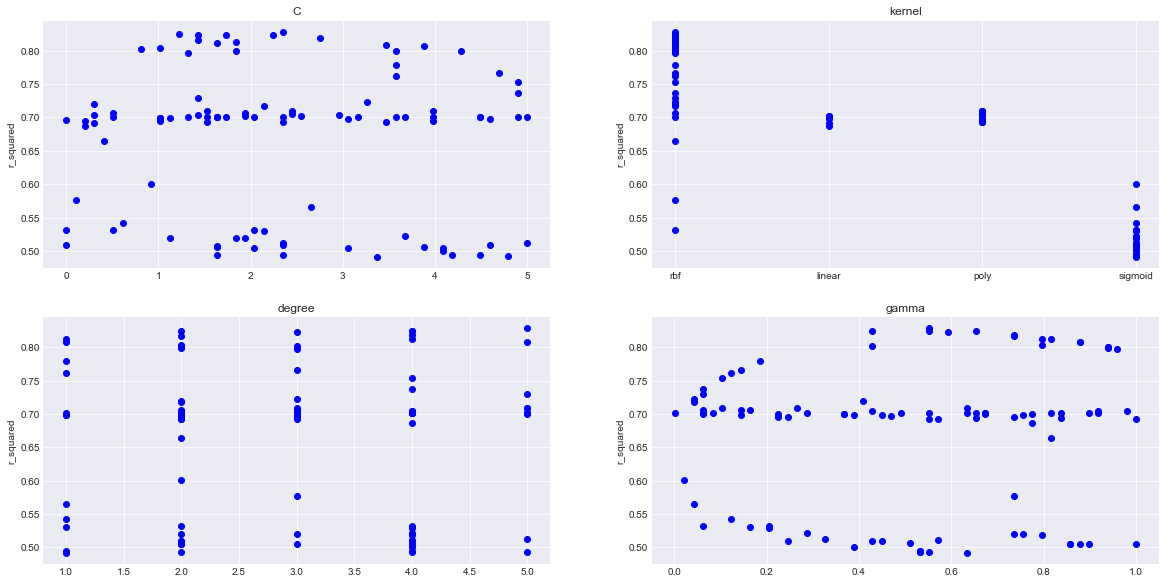

In [41]:
out2 = pd.DataFrame(svc_random.cv_results_)

xlabel_names = ['C',
               'kernel',
               'degree',
               'gamma']

fig, axs = plt.subplots(2,2, figsize=(20,10))

axs[0,0].scatter(out2['param_C'], out2['mean_test_score'], c='blue');
axs[0,0].set_title('C')

axs[0,1].scatter(out2['param_kernel'], out2['mean_test_score'], c='blue');
axs[0,1].set_title('kernel')

axs[1,0].scatter(out2['param_degree'], out2['mean_test_score'], c='blue');
axs[1,0].set_title('degree')

axs[1,1].scatter(out2['param_gamma'], out2['mean_test_score'], c='blue');
axs[1,1].set_title('gamma')

for ax in axs.flat: ax.set(ylabel='r_squared')

In [42]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve


C = [round(x,5) for x in np.linspace(start = 1, stop = 3, num = 30)]
kernel = [ 'rbf']
degree = [2,3,4]
gamma = [round(x,5) for x in np.linspace(start = 0.4, stop = 0.6, num = 10)]
#gamma = ['auto', 0.3,0.5, 0.7,0.9]

random_grid = {'C': C,
               'kernel': kernel,
               'degree':degree,
               'gamma': gamma}
svc = SVC()
svc_grid = GridSearchCV(estimator = svc, param_grid = random_grid,  cv = 3, verbose=2,  n_jobs = -1)

isotonic_svm = CalibratedClassifierCV(svc_grid, cv=3, method='isotonic')
isotonic_svm.fit(X_trainval_smote, y_trainval_smote)


Fitting 3 folds for each of 900 candidates, totalling 2700 fits
Fitting 3 folds for each of 900 candidates, totalling 2700 fits
Fitting 3 folds for each of 900 candidates, totalling 2700 fits


CalibratedClassifierCV(base_estimator=GridSearchCV(cv=3, estimator=SVC(),
                                                   n_jobs=-1,
                                                   param_grid={'C': [1.0,
                                                                     1.06897,
                                                                     1.13793,
                                                                     1.2069,
                                                                     1.27586,
                                                                     1.34483,
                                                                     1.41379,
                                                                     1.48276,
                                                                     1.55172,
                                                                     1.62069,
                                                                     1.68966,
           

In [43]:
y_pred_svm = isotonic_svm.predict(X_val)
print(classification_report(y_val, y_pred_svm))
print(classification_report(y_val, y_pred_knn_b))

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98       610
         1.0       0.88      0.98      0.93       190

    accuracy                           0.96       800
   macro avg       0.94      0.97      0.95       800
weighted avg       0.97      0.96      0.96       800

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97       610
         1.0       0.83      0.99      0.90       190

    accuracy                           0.95       800
   macro avg       0.91      0.96      0.94       800
weighted avg       0.96      0.95      0.95       800



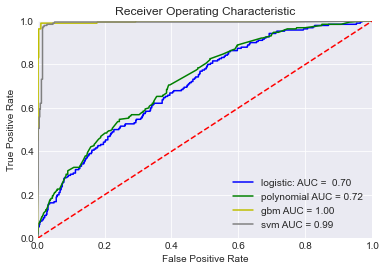

In [44]:
preds_svm = isotonic_svm.predict_proba(X_val)[:,1]


fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
fpr_p, tpr_p, threshold = metrics.roc_curve(y_val, preds_poly)
fpr_g, tpr_g, threshold = metrics.roc_curve(y_val, preds_gbm)
fpr_s, tpr_s, threshold = metrics.roc_curve(y_val, preds_svm)

roc_auc = metrics.auc(fpr, tpr)
roc_auc_p = metrics.auc(fpr_p, tpr_p)
roc_auc_g = metrics.auc(fpr_g, tpr_g)
roc_auc_s = metrics.auc(fpr_s, tpr_s)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'logistic: AUC =  %0.2f' % roc_auc)
plt.plot(fpr_p, tpr_p, 'g', label = 'polynomial AUC = %0.2f' % roc_auc_p)
plt.plot(fpr_g, tpr_g, 'y', label = 'gbm AUC = %0.2f' % roc_auc_g)
plt.plot(fpr_s, tpr_s, 'grey', label = 'svm AUC = %0.2f' % roc_auc_s)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### In the graph above we can see that the GBM algoritm works best in our case so we'll use that one.
And we check the accuracy with the test score:


In [45]:
y_test_pred_gbm = isotonic_gbm.predict(X_test)
print(classification_report(y_test, y_test_pred_gbm))

              precision    recall  f1-score   support

         0.0       0.77      0.91      0.83       752
         1.0       0.40      0.18      0.25       248

    accuracy                           0.73      1000
   macro avg       0.58      0.54      0.54      1000
weighted avg       0.68      0.73      0.69      1000



In [46]:
import joblib
joblib.dump(isotonic_gbm,'pickles/GBM_ClassifierFinal.pkl')

['pickles/GBM_ClassifierFinal.pkl']

## Whitening the black box

In [6]:
import joblib
gbm_classifier = joblib.load('pickles/GBM_ClassifierFinal.pkl')

In [18]:
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_val.values, mode="classification",training_labels=y_val ,feature_names=X_val.columns)

In [25]:
i = 100
X_test = pd.DataFrame(X_test)
X_test.columns = X_val.columns

X_observation = X_test.iloc[[i], :]

In [26]:
gbm_classifier.predict(X_observation)

array([0.])

In [27]:
def wrapped_fn(X):
  p = gbm_classifier.predict(X).reshape(-1, 1)
  return np.hstack((1-p, p))

In [28]:
# explanation using the random forest model
explanation = explainer.explain_instance(X_observation.values[0], wrapped_fn)
explanation.show_in_notebook(show_table=True, show_all=False)

### Explaining results
It wasn't as easy to get info about a classification algoritm than it was to get information about a regression algoritm, because we couldn't get the feature_importances_ of a 'calibratedclassifierCV'.

But if we interpret the graph above we can see that the values of 'bar_no' and 'gender_V' have the biggest for the algoritm

In [56]:
"""
from matplotlib import pyplot as plt

plt.figure(figsize=(20,10))

feat_importances = pd.Series(gbm_classifier.base_estimator.feature_importances_, index=X_val.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()
"""

"\nfrom matplotlib import pyplot as plt\n\nplt.figure(figsize=(20,10))\n\nfeat_importances = pd.Series(gbm_classifier.base_estimator.feature_importances_, index=X_val.columns)\nfeat_importances.nlargest(10).plot(kind='barh')\nplt.show()\n"